In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from avcv.all import *
import torch, torch.nn as nn
from dms_drowsiness.video_writer import Board
import onnxruntime
import numpy as np, cv2
from PIL import Image
from ple.all import *
import torch.utils.data as td


In [ ]:
class Label:
    def __init__(self, label, video):
        self.label = label
        self.video = video
        
    def check_action_at_frame_idx(self, i):
        if isinstance(i, int):
            i = i/self.video.fps
            
        actions = []
        for action in self.label['annotation']['actionAnnotationList']:
            if i >= action['start'] and i < action['end']:
                action_idx = action['action']
                action_name = self.actionid2name[action_idx]
                actions.append(action_name)
        return actions
    @property
    def actionid2name(self):
        if hasattr(self, '_actionid2name'):
            return self._actionid2name
        ret = dict()
        for actionLabel in self.label['config']['actionLabelData']:
            ret[actionLabel['id']] = actionLabel['name']
        self._actionid2name = ret
        return ret

In [ ]:
PRED_DIR_COCO ='/home/anhvth8/gitprojects/YOLOX/.cache/raw_video_predict_face_food'

## Read 2d video feat

In [ ]:
def convert_flatten_to_2d_feature(flatten_sample):
    feat_sizes = [416//8, 416//16, 416//32]
    # reg_orig_shape = np.array(reg_orig_shape)**2
    cur_i = 0
    feats = []
    for feat_size in feat_sizes:
        a = cur_i
        b = a+feat_size**2
        cur_i = b
        feats.append(flatten_sample[a:b].reshape(feat_size, feat_size, -1))
    return feats

def read_raw_feat_one_video(path):
    data = dict(mmcv.load(path))
    # for k in data:
    #     data[k] = convert_flatten_to_2d_feature(data[k])
    return data
    # list_json_paths[0]['raw_feat_path']

In [ ]:
# 

In [ ]:
def anns2tensor(img, anns):
    h, w = img['height'], img['width']
    tensor = []
    for ann in anns:
        x,y,w,h = ann['bbox']
        x /=img['width']
        w /=img['width']
        y /=img['height']
        h /=img['height']
        s = ann['score']
        cat = ann['category_id']
        tensor.append([x,y,w,h,s, cat])
    return np.array(tensor)

In [ ]:
def get_y(actions):
    return action2id[str(actions)]

def get_x_tensor(tensor):
    zt = np.zeros([1,6], dtype=np.float32)
    def get_tensor_cat(cat):
        if len(tensor) == 0:
            return zt
        
        _t = tensor[tensor[:,-1] ==cat]
        
        if len(_t):
            max_id = _t[:,-2].argmax()
            _t = _t[max_id][None]
        else:
            return zt
            
        return _t
    return np.concatenate([get_tensor_cat(i) for i in range(1, 7)])

In [ ]:
def get_M(input_size = [224, 416], num_cls=6):
    """
        return list of mapping [old_start, old_end, new_start, new_end ]
    """
    M = []
    target_f_size = []
    
    cur_i = 0
    o_cur_i = 0

    for i in [8,16,32]:
        h, w = input_size
        _h, _w = h//i, w//i
        _oh = _ow = 416//i

        a, b = cur_i,cur_i +_h*_w
        oa, ob = o_cur_i,o_cur_i +_oh*_oh
        cur_i = b
        o_cur_i = ob
        M.append([oa, ob, _h*_w, _h, _w])
        
    return M, _h*_w*num_cls

INP_SHAPE = (224,416)
INP_SHAPE_STR = '_'.join([str(_) for _ in INP_SHAPE])
M, IN_CHANNEL_CLS = get_M(INP_SHAPE)
M, IN_CHANNEL_CLS, INP_SHAPE_STR

([[0, 2704, 1456, 28, 52], [2704, 3380, 364, 14, 26], [3380, 3549, 91, 7, 13]],
 546,
 '224_416')

In [ ]:

def convert_f(f):
    fs = []
    for oa,ob,ab,_,_ in M:
        # print(oa,ob,ab)
        fs.append(f[oa:ob][:ab].reshape(-1, 11))
    feat1d = np.concatenate(fs)
    return preproc_feat1d(feat1d)

def preproc_feat1d(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)[None]
    x = x[...,4:5]*x[...,5:]
    xs = []
    cur_i = 0
    for i, _ in enumerate(M):
        h,w = _[-2:]
        _x = x[:, cur_i:cur_i+h*w].reshape([-1, h, w, 6]).permute([0,3,1,2])

        pool_size = 2**(2-i)
        _x = nn.functional.max_pool2d(_x, pool_size)
        cur_i += h*w
        xs.append(_x)
    fuse = sum(xs)
    return fuse.numpy()[0]

In [ ]:
VIDEO_RAW_DIR_FOOD = '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/'
VIDEO_RAW_DIR_CIGARRET = '/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS'
VAL_USERS = ['hungng', 'chungtd12', 'thomp4', 'thuyhv5']

### get_meta_jsons

In [ ]:
def get_meta_jsons(input):
    """
        Asumming 
    """
    if input.endswith('.mp4'):
        video_path = input
        label_path = input.replace('.mp4', '.json')
    else:
        label_path = input
        video_path = input.replace('.mp4', '.json')

    video_name = get_name(label_path)
    
    pred_json_path = f'{PRED_DIR_COCO}/{video_name}/annotations/pred_mb2_face_food.json'
    # if not osp.exists(pred_json_path):
    #     logger.warning(f'404 {pred_json_path=}')
    assert osp.exists(pred_json_path), f'404 {pred_json_path}'
    assert osp.exists(video_path), f'404 {video_path}'
    # if not osp.exists(video_path):
        # logger.warning(f'404 {video_path=}')
        
        
    if not osp.exists(label_path):
        logger.warning(f'404 {label_path=}')
        label_path = None
    
    return dict(
        pred_json_path=pred_json_path,
        label_path = label_path,
        video_path=video_path,
    )


list_json_paths = []
tobe_extract_videos = []

label_paths  = glob(f'{VIDEO_RAW_DIR_FOOD}/**/*.json', recursive=True)
for label_path in label_paths:
    try:
        json_paths = get_meta_jsons(label_path)
        list_json_paths.append(json_paths)
    except Exception as e:
        print(e)
        tobe_extract_videos.append(label_path.replace('.json', '.mp4'))
        pass

label_paths = glob(f'{VIDEO_RAW_DIR_CIGARRET}/*/**/*.json', recursive=True)

for label_path in label_paths:
    try:
        json_paths = get_meta_jsons(label_path)
        list_json_paths.append(json_paths)
    except Exception as e:
        print(e)
        tobe_extract_videos.append(label_path.replace('.json', '.mp4'))
        pass
len(list_json_paths)

109

### video_to_coco_format

In [ ]:
def construct_cmd(video_inp, dry_run=True):
    cmd=f"python tools/eval_export.py -f exps/dms/mb2_face_food.py --input_video {video_inp} --out_dir .cache/raw_video_predict_face_food/ -d 1"
    if not dry_run:
        os.system(cmd)
    return cmd

def video_to_coco_format(tobe_extract_videos):


    if len(tobe_extract_videos):
        with open('/tmp/listcmd.sh', 'w') as f:
            for video in tobe_extract_videos:
                cmd = construct_cmd(video)
                f.write(cmd+'\n')
        !python scripts/run_list_commands.py /tmp/listcmd.sh 8 

    else:
        print('All video are extracted to coco-format :D')
        
video_to_coco_format(tobe_extract_videos)

All video are extracted to coco-format :D


# Extract coco-format prediction of detection model

In [ ]:
def collect_data(inp):
    index, json_paths = inp
    v = mmcv.VideoReader(json_paths['video_path'])
    label = Label(mmcv.load(json_paths['label_path']), v)
    cc = CocoDataset(json_paths['pred_json_path'])
    data = []
    # raw_feat2d = read_raw_feat_one_video(json_paths['raw_feat_path'])
    for i, frame in enumerate(v):
        actions = label.check_action_at_frame_idx(i)
        anns = cc.gt.imgToAnns[i]
        img = cc.gt.imgs[i]
        tensor = None#anns2tensor(img, anns)
        img_path = osp.join(cc.img_dir, img['file_name'])
        feat = None#raw_feat2d[img['id']]
        data.append((actions[0] if len(actions) else 'none' , index, img_path, img['id']))
        
    return data


In [ ]:
%%time

CACHE_DF_PATH = '/tmp/eating_cache_data_df.pkl'
if not osp.exists(CACHE_DF_PATH) or 0:
    list_json_paths = []


    label_paths  = glob('/data/DMS_Behavior_Detection/RawVideos/Action_Eating/**/*.json', recursive=True)
    for label_path in label_paths:
        try:
            json_paths = get_data(label_path, 'food')
            list_json_paths.append(json_paths)
        except Exception as e:
            print(e)
            pass

    label_paths  = glob('/data/DMS_Behavior_Detection/mobile_cigarret_foreignerUS/*/**/*.json', recursive=True)
    print(f'{len(label_paths)=}')
    for label_path in label_paths:
        try:
            json_paths = get_data(label_path, 'food')
            list_json_paths.append(json_paths)
        except Exception as e:
            print(e)
            pass
    len(list_json_paths)    
    
    
    print('Collecting data from scratch')
    data = multi_thread(collect_data, list(enumerate(list_json_paths)), verbose=1, pbar_iterval=10)
    all_data = []
    for _ in data: all_data += _

    df = pd.DataFrame(all_data, columns=['action', 'video_index', 'img_path', 'img_id'])
    #-smocking->smoking
    ids = df[df['action'] == 'smocking'].index
    df.loc[ids, 'action'] = 'smoking'
    mmcv.dump(df, CACHE_DF_PATH)
else:
    print(f'Load data from {CACHE_DF_PATH=}')
    df = mmcv.load(CACHE_DF_PATH)

Load data from CACHE_DF_PATH='/tmp/eating_cache_data_df.pkl'
CPU times: user 81.8 ms, sys: 19.7 ms, total: 101 ms
Wall time: 101 ms


In [ ]:

df['username'] = df.img_path.apply(lambda x:x.split('/')[-3].split('_')[0])
df['is_val'] = df['username'].apply(lambda x: x in VAL_USERS)

In [ ]:
_id2action = dict(enumerate(df['action'].apply(str).unique().tolist()))
action2id = {v:k for k, v in _id2action.items()}
id2action = {k:v for k, v in _id2action.items()}
print(action2id)


{'eating': 0, 'none': 1, 'mobile usage': 2, 'smoking': 3}


## Split train/val

### Produce x/y columns

In [ ]:
df['x'] = df['img_path']
df['y'] = df.action.apply(lambda x: action2id[x])

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, ytrain = df[~df.is_val]['x'].tolist(), df[~df.is_val]['y'].tolist()
xval, yval = df[df.is_val]['x'].tolist(), df[df.is_val]['y'].tolist()
print(len(xtrain), len(xval))

79881 4593


## Dataset

In [ ]:
def load_image_tensor(path):
    img = mmcv.imread(path, 0)
    img = mmcv.imrescale(img, INP_SHAPE)
    img = mmcv.impad(img, shape=INP_SHAPE, pad_val=114)
    img = img[None].astype(np.float32)
    return torch.from_numpy(img)

class ImageDataset:
    def __init__(self, img_paths, y=None):
        self.img_paths = img_paths
        self.y = y if y is not None else [0]*len(img_paths)
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, i):
        return load_image_tensor(self.img_paths[i]), self.y[i], self.img_paths[i]



### Get sample data

In [ ]:
ds = ImageDataset(df.img_path, df.y)
dl = td.DataLoader(ds, 100, shuffle=1)
x,y, img_paths = next(iter(dl))

# MODEL

## CLIP teacher

In [ ]:
# !pip install git+https://github.com/openai/CLIP

### ClipFinetuningDataset

In [ ]:
from scripts.clip_finetuning_exp import get_clip_model

In [ ]:
class CLipCLS(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.model, self.image_processor = get_clip_model('cpu')
        self.final_cls = nn.Linear(512, 4)
        
    def forward(self, x):
        x = self.model.encode_image(x)
        x = self.final_cls(x)
        return x

In [ ]:
cliplit = ClipLit()
st = torch.load('lightning_logs/finetune_clip/05/ckpts/last.ckpt')['state_dict']
res = cliplit.load_state_dict(st)

In [ ]:
# clip_model, image_processor = get_clip_model('cpu')
# clip_model = LitModel.load_from_checkpoint('lightning_logs/finetune_clip/01/ckpts/last.ckpt' ,model = clip_model).model

In [ ]:
# device = 'cuda'
text_promts = [f"the person is {action}" for action in id2action.values()]
# clip_model.to(device)
# with torch.no_grad():
#     text = clip.tokenize(text_promts).to(device)
#     encoded_texts = clip_model.encode_text(text)
print(text_promts)

def clip_image_infer(model, img, device='cuda'):
    model.to(device)
    img = mmcv.imread(img, channel_order='rgb')
    img = Image.fromarray(img)
    
    image = image_processor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image)
        probs = logits.softmax(1)
    return probs


['the person is eating', 'the person is doing nothing', 'the person is using phone', 'the person is smoking']


In [ ]:
# video = '/data/DMS_Behavior_Detection/RawVideos/Action_Eating/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b/hungng_Sensing_Session0_CAMc_1b_2c_3a_4c_5b_6b_7b_8a_9a_10a_11b_12a_13a_14b_15b_16f_17a_18a_19a_20b_eating_0013.mp4'
# video = mmcv.VideoReader(video)
video = list(sorted(get_files('.cache/raw_video_predict_face_food/vietph_Sensing_Session2_CAMc_1b_2c_3a_4d_5b_6b_7b_8a_9a_10a_11b_12b_13b_14b_15b_16f_17a_18a_19a_20b/images/')))

In [ ]:
len(video)

49195

In [ ]:
# from dms_drowsiness.video_writer import VideoWriter, Board

In [ ]:
# video = mmcv.VideoReader('/data/DMS_Behavior_Detection/RawVideos/UploadedTest/vietph_Sensing_Session2_CAMc_1b_2c_3a_4d_5b_6b_7b_8a_9a_10a_11b_12b_13b_14b_15b_16f_17a_18a_19a_20b.mp4')
vis = []
for frame_idx, frame in tqdm(enumerate(video), total=len(video)):
    if frame_idx%100 == 0:
        board = Board(6)
        # probs = list_probs[frame_idx]
        probs = clip_image_infer(cliplit, frame).squeeze()
        for i, action in enumerate(id2action.values()):
            board.set_line_text(i, str(i), probs[i])
        vis.append(board.img_concat(frame))
        
images_to_video(vis, 'vis.mp4', output_size=(600, 300), fps=5)

100%|███████████████████████████████████████████████████████████████| 49195/49195 [01:00<00:00, 817.21it/s]
2022-09-28 08:24:26.825 | INFO     | avcv.utils:images_to_video:267 - Write video, output_size: (600, 300)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 492/492, 166.8 task/s, elapsed: 3s, ETA:     0s

2022-09-28 08:24:29.777 | INFO     | avcv.utils:images_to_video:277 - -> /home/anhvth8/gitprojects/YOLOX/vis.mp4


## MyLit

In [ ]:
from scripts.export_onnx import SimpleCLS2D, ModelWrapper

class MyLit(LitModel):
    def forward_loss(self, batch, batch_idx, mode):
        x, y = batch[:2]
        y_onehot = nn.functional.one_hot(y, 4).float()
        logits = self(x).reshape_as(y_onehot)
        probs = logits.sigmoid()
        loss = self.loss_fn(logits, y_onehot)
        
        mask = y!=1
        if mask.sum():
            accs = (y_onehot[mask] == (probs[mask]>0.5).float()).float().mean()
            self.log(f"{mode}_acc", accs, prog_bar=True,
                     rank_zero_only=True, on_epoch=True, batch_size=mask.sum())
        self.log(f"{mode}_loss", loss, prog_bar=True,
                 rank_zero_only=True, on_epoch=True)

        return loss
    def training_step(self, b,i): return self.forward_loss(b,i,'training')
    def validation_step(self, b,i): return self.forward_loss(b,i,'val')

IN_CHANNEL_CLS=546


2022-09-28 09:04:58.256 | INFO     | scripts.export_onnx:create_yolox_mb2:67 - <All keys matched successfully>


## PLData

In [ ]:
from ple.all import *
import torch.utils.data as td
import pytorch_lightning as pl
from fastcore.all import *

class PLData(pl.LightningDataModule):
    def __init__(self, **kwargs):
        super().__init__()
        store_attr(**kwargs)

    def train_dataloader(self):
        dataset = ImageDataset(xtrain, ytrain)
        return td.DataLoader(dataset, self.batch_size, num_workers=self.num_workers, drop_last=True, shuffle=True)

    def val_dataloader(self):
        dataset = ImageDataset(xval, yval)
        return td.DataLoader(dataset, self.batch_size, num_workers=self.num_workers,drop_last=True)
pldata = PLData(batch_size=64, num_workers=0)
trainloader = pldata.train_dataloader()
x,y, img_paths = next(iter(trainloader))
print(x.shape, y.shape)

torch.Size([64, 1, 224, 416]) torch.Size([64])


## TriStageExp

In [ ]:
class TriStageExp(BaseExp):

    def __init__(self, exp_name='EXPNAME', 
                 batch_size=64, 
                 num_workers=2, 
                 devices=2,
                 strategy='dp', 
                 **kwargs):
        super().__init__()
        store_attr(**kwargs)

    def get_model(self):
        dl = self.get_data_loader().train_dataloader()
        sched = fn_schedule_cosine_with_warmpup_decay_timm(
            num_epochs=self.max_epochs,
            num_steps_per_epoch=len(dl)//self.devices,
            num_epochs_per_cycle=self.max_epochs//self.num_lr_cycles,
            min_lr=1/100,
            cycle_decay=0.7,
        )
        optim = lambda params:torch.optim.Adam(params)

        return MyLit(self.model, create_optimizer_fn=optim,
                                   create_lr_scheduler_fn=sched, loss_fn=self.loss_fn)

    def get_data_loader(self):
        return PLData(batch_size=self.batch_size, num_workers=self.num_workers)

    def get_trainer(self, **kwargs):
        from ple.trainer import get_trainer
        return get_trainer(self.exp_name, 
                              max_epochs=self.max_epochs, 
                              gpus=self.devices,
                           strategy=self.strategy,
                           **kwargs,

                          )

exp = TriStageExp(exp_name=f'simple_nn/{INP_SHAPE_STR}', batch_size=256, 
                  num_workers=4, devices=1, model=ModelWrapper(), max_epochs=3,
                 loss_fn = BinaryFocalLoss())
lit_model = exp.get_model()
trainer = exp.get_trainer()
trainer.fit(lit_model, exp.get_data_loader())

2022-09-28 09:05:23.779 | INFO     | ple.lit_model:fn_schedule_cosine_with_warmpup_decay_timm:66 - num_cycles=3
2022-09-28 09:05:23.781 | INFO     | ple.trainer:get_trainer:34 - Log root dir: lightning_logs/simple_nn/224_416/26
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/simple_nn/224_416/26/tb_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type            | Params
--------------------------------------------
0 | model   | ModelWrapper    | 21.2 K
1 | loss_fn | BinaryFocalLoss | 0     
--------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


# Test

In [ ]:
ckpt = 'lightning_logs/simple_nn/224_416/26/ckpts/last.ckpt'
res = lit_model.load_from_checkpoint(ckpt, model=lit_model.model)
lit_model = lit_model.cuda().requires_grad_(False).eval()
!python scripts/export_onnx.py {ckpt} out.onnx

### predict_onnx

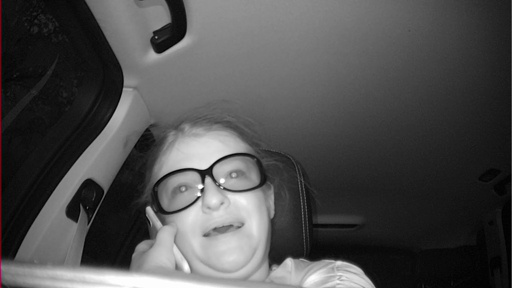

In [ ]:
session = onnxruntime.InferenceSession('/home/anhvth8/gitprojects/YOLOX/out.onnx')

def predict_onnx(img_path):
    inp = load_image_tensor(img_path).numpy()[None]
    ort_inputs = {session.get_inputs()[0].name: inp.astype(np.float32)}
    probs = session.run(None, ort_inputs)[0]
    return torch.from_numpy(probs).sigmoid().numpy().squeeze().tolist()

res = predict_onnx(img_paths[0])
Image.open(img_paths[0])

### Gửi em ảnh test

In [ ]:
# st = torch.load('lightning_logs/simple_nn/224_416/03/ckpts/epoch=0-val_acc=0.86.ckpt')['state_dict']
# new_st = {}
# for k, v in st.items():
#     new_st[k[6:]] = v
# res = model_wraper.classifier.load_state_dict(new_st)
# print(res)
# model_wraper.eval().requires_grad_(False);

In [ ]:
# x,y,img_paths = next(iter(pldata.train_dataloader()))

In [ ]:
# val_json_paths = []
# for json_paths in list_json_paths:
#     username = json_paths['pred_json_path'].split('/')[-3].split('_')[0]
#     if username in val_users:
#         val_json_paths.append(json_paths)
# len(val_json_paths)

In [ ]:
all_videos = glob(f'{VIDEO_RAW_DIR_CIGARRET}/**/*.mp4', recursive=True)+glob(f'{VIDEO_RAW_DIR_FOOD}/**/*.mp4', recursive=True)
val_videos = [v for v in all_videos if get_name(v).split('_')[0] in VAL_USERS]

In [ ]:
meta_videos = []
for path in all_videos:
    meta_videos.append([path, len(mmcv.VideoReader(path))])
meta_videos = pd.DataFrame(meta_videos, columns=['path', 'len']).sort_values('len')

In [ ]:
(meta_videos['len']<100).sum()

15

In [ ]:
# tobe_extract_videos, list_val_jsons = [], []
# for val_video in val_videos:
#     try:
#         list_val_jsons += [get_meta_jsons(val_video) ]
#     except:
#         tobe_extract_videos.append(val_video)
    

In [ ]:
test_video = '/data/DMS_Behavior_Detection/RawVideos/UploadedTest/vietph_Sensing_Session2_CAMc_1b_2c_3a_4d_5b_6b_7b_8a_9a_10a_11b_12b_13b_14b_15b_16f_17a_18a_19a_20b.mp4'
construct_cmd(test_video)

'python tools/eval_export.py -f exps/dms/mb2_face_food.py --input_video /data/DMS_Behavior_Detection/RawVideos/UploadedTest/vietph_Sensing_Session2_CAMc_1b_2c_3a_4d_5b_6b_7b_8a_9a_10a_11b_12b_13b_14b_15b_16f_17a_18a_19a_20b.mp4 --out_dir .cache/raw_video_predict_face_food/ -d 1'

In [ ]:
# from tools.demo import Predictor
# from scripts.export_onnx import CLASSES, create_yolox_mb2, mb2_yolox

# predictor = Predictor(mb2_yolox.cpu(), yolox_mb2_exp, CLASSES, device='cuda')
# outputs, img_info = predictor.inference(img_paths[0])
# result_image = predictor.visual(outputs[0], img_info, )
# Image.fromarray(result_image)

[0.04487387090921402, 0.12801197171211243, 0.6679722666740417, 0.05181141942739487]


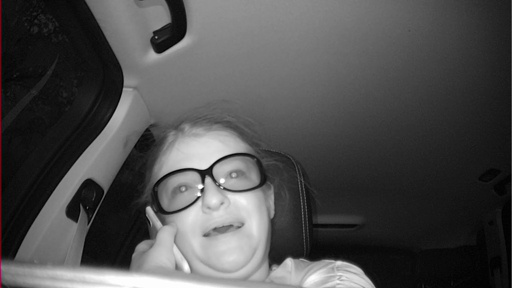

In [ ]:
# @torch.inference_mode()
def predict_model_wrapper(img_path, device='cuda'):
    lit_model.eval().to(device)
    with torch.no_grad():
        img = load_image_tensor(img_path)[None].to(device)
        probs = lit_model(img).cpu().sigmoid()
    return probs.squeeze().tolist()
res = predict_model_wrapper(img_paths[0])
print(res)
Image.open(img_paths[0])

In [ ]:
from IPython.display import clear_output

class Visualize:
    def __init__(self, video_or_json_paths):
        if isinstance(video_or_json_paths, dict):
            json_paths = video_or_json_paths
            self.cc = CocoDataset(json_paths['pred_json_path'])
            if json_paths['label_path'] is not None:
                self.label = Label(mmcv.load(json_paths['label_path']), mmcv.VideoReader(json_paths['video_path']))
            else:
                self.label = None
                
            self.input_type = 'coco'
        elif isinstance(video_or_json_paths, str):
            self.video = mmcv.VideoReader(video_or_json_paths)
            self.input_type = 'video'

    def visualize_coco_frame(self, img):
        cc, label = self.cc, self.label
        board = Board(num_lines=6, line_w=500)
        frame = self.cc.visualize(img, score_thr=0.05);
        img_info = cc.gt.imgs[img]
        image = osp.join(cc.img_dir, img_info['file_name'])
        if label is not None:
            lbl = label.check_action_at_frame_idx(img)
            lbl = lbl[0] if len(lbl) else lbl
        else:
            lbl = None
        probs = predict_onnx(image)
        for class_idx in range(4):
            action = _id2action[class_idx]
            action = action + ' '*(12-len(action))
            score = probs[class_idx]
            board.set_line_text(class_idx, action, score)
        if lbl is not None:
            board.set_line_text(5, f'Label: {lbl}')

        vis = board.img_concat(frame)
        return vis
    
    def visualize_video_frame(self, img):
        
        board = Board(num_lines=6, line_w=500)
        frame = img = mmcv.imread(img)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        probs = predict_onnx(img)
        
        for class_idx in range(4):
            action = _id2action[class_idx]
            action = action + ' '*(12-len(action))
            score = probs[class_idx]
            board.set_line_text(class_idx, action, score)

        vis = board.img_concat(frame)
        return vis

    
    def write_video(self, out_vis_path='vis.mp4'):
        if self.input_type == 'coco':
            vis_list = multi_thread(self.visualize_coco_frame, self.cc.img_ids[0::3], 8, desc='Get Visualize Imgs')
        else:
            vis_list = []
            pbar = mmcv.ProgressBar(len(self.video))
            for frame_idx, img in enumerate(self.video):
                if frame_idx%3==0:
                    vis_list.append(self.visualize_video_frame(img))
                if frame_idx%10 == 0: pbar.update(10)

        images_to_video(vis_list, out_vis_path, output_size=(800, 300))


json_paths = get_meta_jsons(test_video)
vname = json_paths['pred_json_path'].split('/')[-3]
Visualize(json_paths).write_video('val_vis_videos/'+vname+'.mp4')


2022-09-28 09:11:30.637 | WARNING  | __main__:get_meta_jsons:24 - 404 label_path='/data/DMS_Behavior_Detection/RawVideos/UploadedTest/vietph_Sensing_Session2_CAMc_1b_2c_3a_4d_5b_6b_7b_8a_9a_10a_11b_12b_13b_14b_15b_16f_17a_18a_19a_20b.json'
2022-09-28 09:11:34.630 | INFO     | avcv.process:multi_thread:25 - Get Visualize Imgs


[>>>>>>>>>>>>>>>>>>>>>>>] 16400/16399, 155.6 task/s, elapsed: 105s, ETA:     0s

2022-09-28 09:13:20.078 | INFO     | avcv.process:multi_thread:34 - multi_thread visualize_coco_frame, Get Visualize Imgs
2022-09-28 09:13:20.099 | INFO     | avcv.utils:images_to_video:267 - Write video, output_size: (800, 300)


[>>>>>>>>>>>>>>>>>>>>>>>>] 16400/16399, 226.7 task/s, elapsed: 72s, ETA:     0s

2022-09-28 09:14:32.489 | INFO     | avcv.utils:images_to_video:277 - -> /home/anhvth8/gitprojects/YOLOX/val_vis_videos/vietph_Sensing_Session2_CAMc_1b_2c_3a_4d_5b_6b_7b_8a_9a_10a_11b_12b_13b_14b_15b_16f_17a_18a_19a_20b.mp4
